### An Example Notebook Using Utilities

A notebook that shows how to interact with some of these utilities

In [9]:
import os
import sys
import numpy as np
from copy import copy, deepcopy
import matplotlib.pyplot as plt
sys.path.append('avutils')
sys.path.append('avutils/perception')

# NOTE: the "importlib.reload" is just so I can incorporate new changes without kernel reset
import importlib
import avutils
import avutils.perception.data_managers as data_managers
importlib.reload(avutils.perception.data_managers)

import avutils.perception.maskfilters as maskfilters
importlib.reload(avutils.perception.maskfilters)

import avutils.perception.visualize as visualize
importlib.reload(avutils.perception.visualize)

KITTI_data_dir = os.path.join(os.getcwd(), 'data/KITTI/object')

In [2]:
#------Get KITTI data for the tests
KDM = data_managers.KittiDataManager(root_dir=KITTI_data_dir)
idx_frame_extract = 19
img = KDM.get_image(idx_frame_extract)
pc = KDM.get_lidar(idx_frame_extract)
cal = KDM.get_calibration(idx_frame_extract)
labs = KDM.get_labels(idx_frame_extract)
ground = KDM.get_ground(idx_frame_extract, calib=cal)

### Use Visualization to Show Data

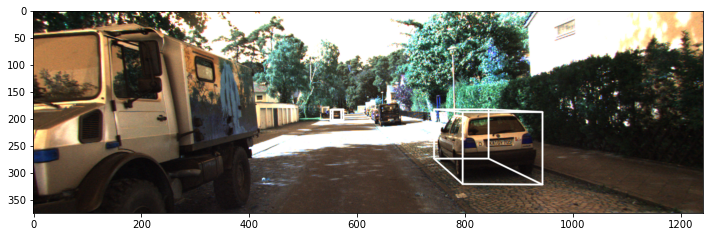

In [3]:
visualize.show_image_with_boxes(img, labs, cal, inline=True)

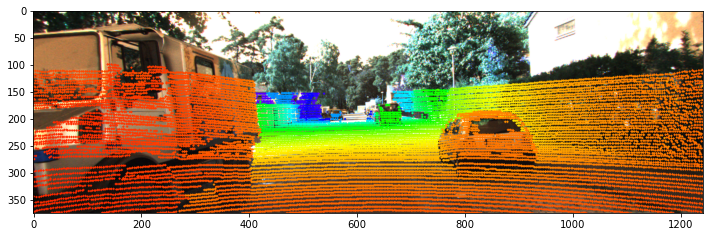

In [4]:
visualize.show_lidar_on_image(pc, img, cal, inline=True)

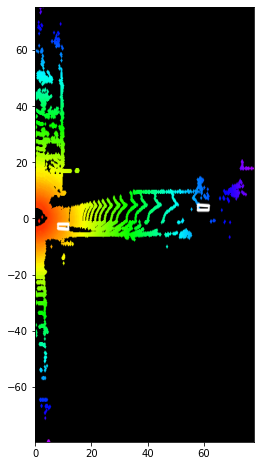

In [5]:
visualize.show_lidar_bev(pc, ground=ground, calib=cal, labels=labs)

### Show Some Masking/Filtering Operations

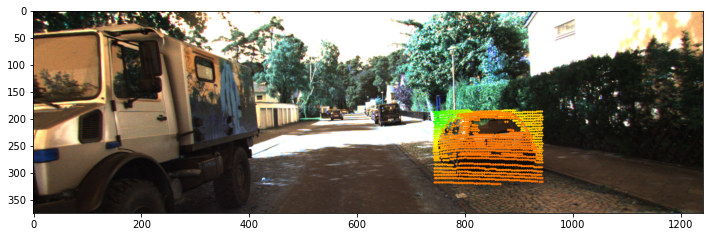

In [6]:
pc_filter_frustum = maskfilters.filter_points_in_frustum(pc, labs[0].box2d, cal)
pc_frustum = pc[pc_filter_frustum, :]
visualize.show_lidar_on_image(pc_frustum, img, cal, inline=True)

In [8]:
pc_filter_bbox = maskfilters.filter_points_in_object_bbox(pc, labs[0].box3d, cal)
pc_bbox = pc[pc_filter_bbox, :]
visualize.show_lidar_on_image(pc_bbox, img, cal, inline=True)

## Spherical Coordinates

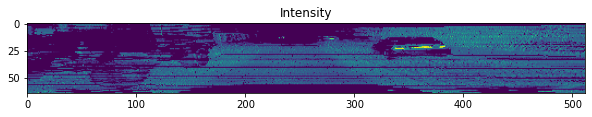

In [50]:
import avutils.tforms as tforms
importlib.reload(tforms)

lidar_test_sph = KDM.get_lidar(19)
sph_img = tforms.project_cartesian_to_5_channel_spherical(lidar_test_sph)

fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.imshow(sph_img[:,:,3])
plt.title('Intensity')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.imshow(sph_img[:,:,4])
plt.title('Range')
plt.show()

### Show How To Use The Detection Result

In [8]:
# make a "fake" detection
lab_detected = deepcopy(labs[0])
lab_detected.box3d.t[2] += 1.2

In [9]:
KDR = data_managers.KittiDetectionResult(detected=lab_detected, truth=labs[0])

In [10]:
KDR

----
KITTI Detection:
 Detected - KITTI Object3DLabel:
  Type=Car
 Box2D=[742.41, 184.49, 944.56, 321.39]
  Box3D=[h: 1.46, w: 1.60, l: 3.71] x (x: 2.84 y: 1.63, z: 10.92)
  ry: -1.54


 Truth - KITTI Object3DLabel:
  Type=Car
 Box2D=[742.41, 184.49, 944.56, 321.39]
  Box3D=[h: 1.46, w: 1.60, l: 3.71] x (x: 2.84 y: 1.63, z: 9.72)
  ry: -1.54

----

In [11]:
KDR.print_stats()

STATS:
  IOU 2D:     1.000
  IOU 2D BEV: 0.494
  IOU 3D:     0.494


## Using Coordinate Transformations

In [12]:
# Take lidar and change to camera rect
pc_in_camera_rect = cal.project_velo_to_rect(pc)

Range to label: 10.26m


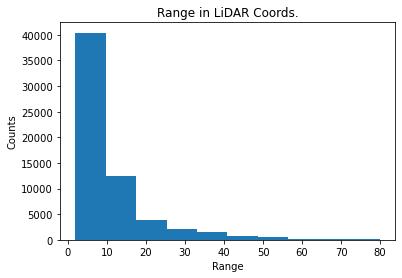

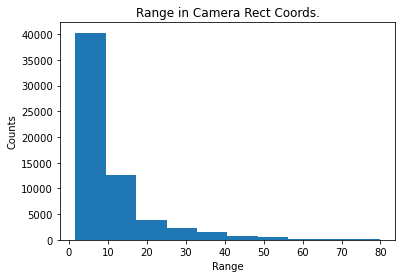

In [25]:
# Get the ranges - should be the same in both coordinates
range_label = labs[0].get_range(cal)
print('Range to label: {:.2f}m'.format(range_label))

# Make histogram of range to points - remember not the intensity
plt.hist(np.linalg.norm(pc[:,0:3], axis=1))
plt.xlabel('Range')
plt.ylabel('Counts')
plt.title('Range in LiDAR Coords.')
plt.show()


plt.hist(np.linalg.norm(pc_in_camera_rect[:,0:3], axis=1))
plt.xlabel('Range')
plt.ylabel('Counts')
plt.title('Range in Camera Rect Coords.')
plt.show()